<a href="https://colab.research.google.com/github/YCherL/Course8-Practical-Machine-Learning-Project/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    # Install packages
    %pip install harmonic emcee getdist

In [2]:
%%capture
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import harmonic as hm
import emcee
import jax.numpy as jnp
import jax
import scipy.special as sp

%config InlineBackend.figure_format = 'retina' # for nicer plots

# Part 1. Basic usage

### Define Bayesian posterior function
---

Now we will need to define the log-posterior function of interest.

As a working example for this basic tutorial we consider a log-likelihood given a standard 2-dimensional Gaussian

$$
f(x) = -\frac{1}{2}x^{T}\Sigma^{-1}x
$$

where for simplicity we have taken the mean $\mu=0$ and dropped scaling factors, and assume a box prior over an finite symetrical interval of width $a$. Under such conditions the log-posterior is given by

In [3]:
def ln_prior_uniform(x, prior_bounds):
    """
    Compute log_e prior in the given bounds, returning -inf outside the bounds.

    Args:
        x: Position at which to evaluate prior.
        prior_bounds: Array of shape (d, 2) specifying lower and upper bounds for each dimension.
    Returns:
        double or array: Scalar of log prior density of x if x is 1D, else array of log prior densities.
    """
    assert prior_bounds.ndim == 2 and prior_bounds.shape[1] == 2, (
        "prior_bounds must be of shape (n, 2)"
    )
    lower, upper = prior_bounds[:, 0], prior_bounds[:, 1]
    inside = jnp.all((x >= lower ) & (x <= upper), axis=-1)
    log_volume = jnp.log(jnp.prod(upper - lower))
    ln_prior = jnp.where(inside, -log_volume, -jnp.inf)
    return ln_prior


def ln_likelihood_gaussian(x, inv_cov):
    """
    Compute log_e of n dimensional multivariate Gaussian likelihood.
    Args:
        x: Position(s) at which to evaluate likelihood.
        inv_cov: Inverse covariance matrix of the Gaussian.
    Returns:
        double or array: Value or array of log likelihoods at x.
    """
    exponent = -0.5 * jnp.einsum("...i,ij,...j", x, inv_cov, x)
    return exponent


def ln_posterior(x, inv_cov, prior_bounds):
    """Compute log_e of posterior of n dimensional multivariate Gaussian.

    Args:

        x: Position at which to evaluate posterior.

    Returns:

        double: Value of posterior at x.

    """
    ln_prior = ln_prior_uniform(x, prior_bounds)
    ln_likelihood = ln_likelihood_gaussian(x, inv_cov)
    ln_posterior = ln_prior + ln_likelihood
    return ln_posterior

Let's enable double precision to avoid rounding errors!

In [4]:
jax.config.update("jax_enable_x64", True)

### Compute samples using `emcee`
---

We then sample from the posterior using an MCMC algorithm. While any MCMC approach can be used we sample using the `emcee` package.

First we will need to define and initialise some variables.

In [5]:
# Define parameters for emcee sampling
ndim = 5                    # Dimensions
nchains = 30                # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Construct a trivial inverse covariance (identity matrix) and prior bounds
inv_cov = np.zeros((ndim,ndim))
diag_cov = np.ones(ndim)
np.fill_diagonal(inv_cov, diag_cov)
prior_bounds = np.array([[-10, 10]] * ndim)

Now we need to run the sampler.

In [6]:
# initialise random seed
np.random.seed(1)

# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim))
rstate = np.random.get_state()

# Instantiate and execute sampler
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[inv_cov, prior_bounds], vectorize=True)
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate, progress=True)

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

100%|██████████| 5000/5000 [00:21<00:00, 232.65it/s]


## Compute evidence using `harmonic`
---

`harmonic` requires only posterior samples.  There are no constraints on the type of sampling algorithm used.

Once we have posterior samples to hand, they can be post-processed using `harmonic` to compute the Bayesian evidence.

### Collating samples using `harmonic.chains` class

We first configure the chains into a `harmonic`-friendly shape, which we do as follows.

In [7]:
# Instantiate harmonic's chains class
chains = hm.Chains(ndim)
chains.add_chains_3d(samples, lnprob)

Since we will subsequently learn the target distribution $\varphi$ we split the samples into training and inference sets.

In [8]:
# Split the chains into the ones which will be used to train the machine
# learning model and for inference
chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.5)

### Train the machine learning model

We simply select the model we wish to adopt and fit the model.

In [9]:
# Select RQSpline Model
temperature = 0.8
model = hm.model.RQSplineModel(ndim, standardize=True, temperature=temperature)
epochs_num = 15
# Train model
model.fit(chains_train.samples, epochs=epochs_num, verbose=True, batch_size=256)

Training NF: 100%|██████████| 15/15 [02:58<00:00, 11.89s/it]


### Posterior triangle plot

Let's also plot slices of the posterior using these samples to see what we're working with! It is important for the concentrated flow (here we set temperature equal to 0.8) to be contained within the posterior. If this is not the case, the evidence estimate will not be accurate. If the flow is not contained within the posterior, try reducing the temperature or learning the posterior better by training for longer or changing the model architecture or hyperparameters.

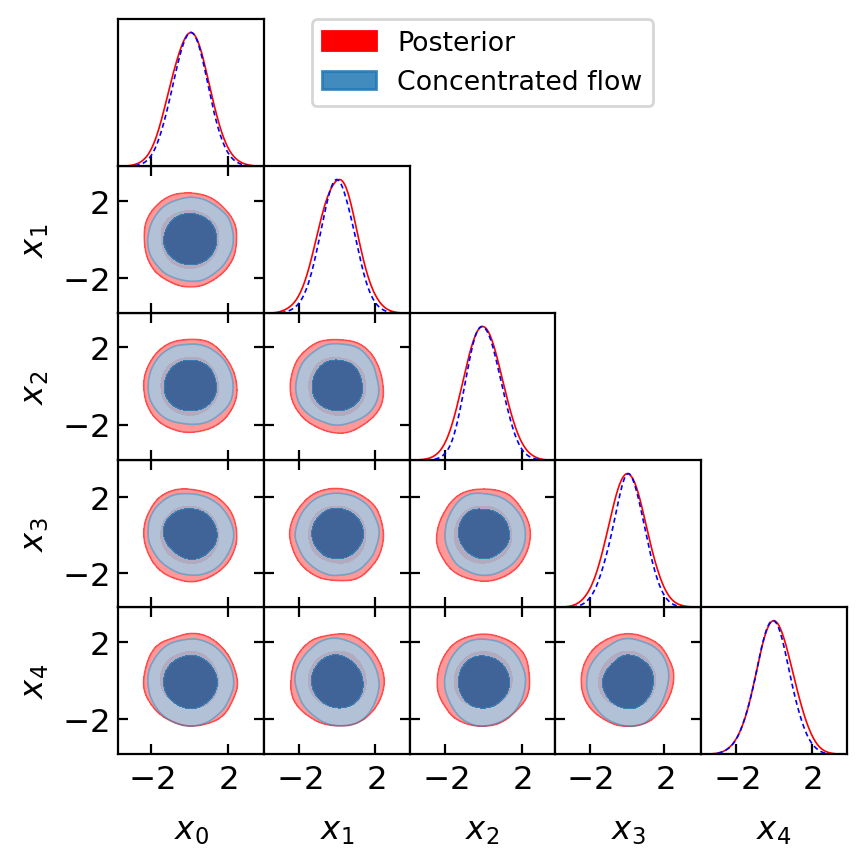

In [10]:
samples = samples.reshape((-1, ndim))
samp_num = samples.shape[0]
flow_samples = model.sample(samp_num)
hm.utils.plot_getdist_compare(samples, flow_samples)

### Compute the Bayesian evidence

Finally we simply compute the learned harmonic mean estimator as follows.

In [11]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_infer.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_infer)
ln_inv_evidence = ev.ln_evidence_inv
err_ln_inv_evidence = ev.compute_ln_inv_evidence_errors()

We typically always work in log space to avoid issues with over/underflow especially since evidence values can get quite extreme!

## Results
---

Let's check the evidence value computed.

### Analytic value

As this is a standard n-dimensional Gaussian the evidence is analytically tractable and given by

In [12]:
def ln_evidence_analytic_gaussian_box(inv_cov, prior_bounds):
    """
    Computes the analytic log evidence for a box prior, assuming that the prior
    is much wider than the Gaussian likelihood.

    Args:
        inv_cov: Inverse covariance matrix of the Gaussian likelihood.
        prior_bounds: Array of shape (d, 2) specifying lower and upper bounds for each dimension.
    Returns:
        double: Analytic log evidence.
    """
    d = len(prior_bounds)
    ln_evidence = 0.5 * (d * np.log(2* jnp.pi) - jnp.linalg.slogdet(inv_cov)[1])
    for bound in prior_bounds:
        ln_evidence -= jnp.log(bound[1] - bound[0])
    return ln_evidence

ln_inv_evidence_analytic = -ln_evidence_analytic_gaussian_box(inv_cov, prior_bounds)

Let's compare the value computed by `harmonic` and analytically

In [13]:
print('ln inverse evidence (harmonic) = {} +/- {}'.format(ln_inv_evidence, err_ln_inv_evidence))
print('ln inverse evidence (analytic) = {}'.format(ln_inv_evidence_analytic))
print('nsigma = {}'.format(np.abs(ln_inv_evidence - ln_inv_evidence_analytic) / err_ln_inv_evidence))

ln inverse evidence (harmonic) = 10.382168121369624 +/- (np.float64(-0.005401613151685759), np.float64(0.005372592415651408))
ln inverse evidence (analytic) = 10.383968701746591
nsigma = [-0.33334123  0.33514182]


As expected, the evidence computed by `harmonic` is close to that computed analytically.

# Part 2. Diagnostics

Apart from inspecting the flow visually, we should check the quality of the estimate using diagnostic metrics provided by `harmonic`. This is an important indication of whether the error estimate of the evidence is precise.


### 1. Kurtosis
By the central limit theorem, for a large number of samples the distribution of inverse evidence estimated for each chain $j$, $\hat{\rho_{j}}$ approaches a Gaussian, with kurtosis $\kappa = 3$. If the estimated kurtosis $\hat{\kappa} \gg 3$ it would indicate that the sampled distribution of $\hat{\rho_{j}}$ has long tails, suggesting further samples need to be drawn, or a better contained flow should be used.

### 2. Variance of Variance Check
This diagnostic compares the ratio of the variance of the variance, to the variance itself (of the inverse evidence). By the central limit theorem, the ratio should be approximately:

$$\sqrt{\frac{2}{n_{\text{eff}} - 1}}$$

where $n_{\text{eff}}$ is the effective sample size. If the ratio is significantly larger than this value, it indicates that the variance estimate is not precise, and more samples are needed.

We keep track of these measures when computing the evidence, and they are then stored as attributes of the Evidence class.

Let's compute the diagnostics:

In [14]:
print("kurtosis = {}".format(ev.kurtosis), " Aim for ~3.")
check = np.exp(0.5 * ev.ln_evidence_inv_var_var - ev.ln_evidence_inv_var)

print("sqrt(evidence_inv_var_var) / evidence_inv_var = {}".format(check))
print(" Aim for sqrt( 2/(n_eff-1) ) = {}".format(np.sqrt(2.0 / (ev.n_eff - 1))))

kurtosis = 2.1780445499494325  Aim for ~3.
sqrt(evidence_inv_var_var) / evidence_inv_var = 0.2769659595557173
 Aim for sqrt( 2/(n_eff-1) ) = 0.3779644730092272


Diagnostics are looking good for our Gaussian!

# Part 3. Polynomial model comparison

Let's now consider Bayesian model comparison of polynomial models fitted to synthetic data.

We want to determine the degree that best describes the data without including unnecessary complexity.

In [15]:
# Set random seed for reproducibility
np.random.seed(42)


# Helper: evaluate polynomial given coefficients in increasing power order
def model_predict(params, x):
    """Evaluate polynomial with coefficients `params = [a0, a1, ...]`

    Returns y = a0 + a1*x + a2*x^2 + ...

    `np.polyval` expects highest-to-lowest order, so we flip.
    """
    y = np.polyval(np.flip(params), x)
    return y

## Generate synthetic data

Generate a small synthetic dataset by selecting a polynomial order and
adding Gaussian observation noise.

Options for the true model to be ``linear``, ``quadratic``, ``cubic``, or ``quartic`` and to set the true parameters

In [16]:
# Choose the underlying truth model
truth_model = "cubic"  # options: 'linear', 'quadratic', 'cubic', 'quartic'

# Observation settings
noise_std = 2.0  # Standard deviation of the Gaussian noise
num_data_points = 20
x_data = np.linspace(-3, 3, num_data_points)

# True polynomial coefficients (a_k corresponds to x^k)
a0_true = -2.0  # constant term
a1_true = -1.0  # linear term
a2_true = 0.2  # quadratic term
a3_true = 0.5  # cubic term
a4_true = 0.0  # quartic term

if truth_model == "linear":
    y_true_noiseless = model_predict([a0_true, a1_true], x_data)
elif truth_model == "quadratic":
    y_true_noiseless = model_predict([a0_true, a1_true, a2_true], x_data)
elif truth_model == "cubic":
    y_true_noiseless = model_predict([a0_true, a1_true, a2_true, a3_true], x_data)
elif truth_model == "quartic":
    y_true_noiseless = model_predict(
        [a0_true, a1_true, a2_true, a3_true, a4_true], x_data
    )
else:
    raise ValueError(
        "Truth_model must be one of 'linear', 'quadratic', 'cubic', 'quartic'"
    )

# Add Gaussian noise to y values
y_data = y_true_noiseless + np.random.normal(
    loc=0.0, scale=noise_std, size=num_data_points
)

Let's plot the data:

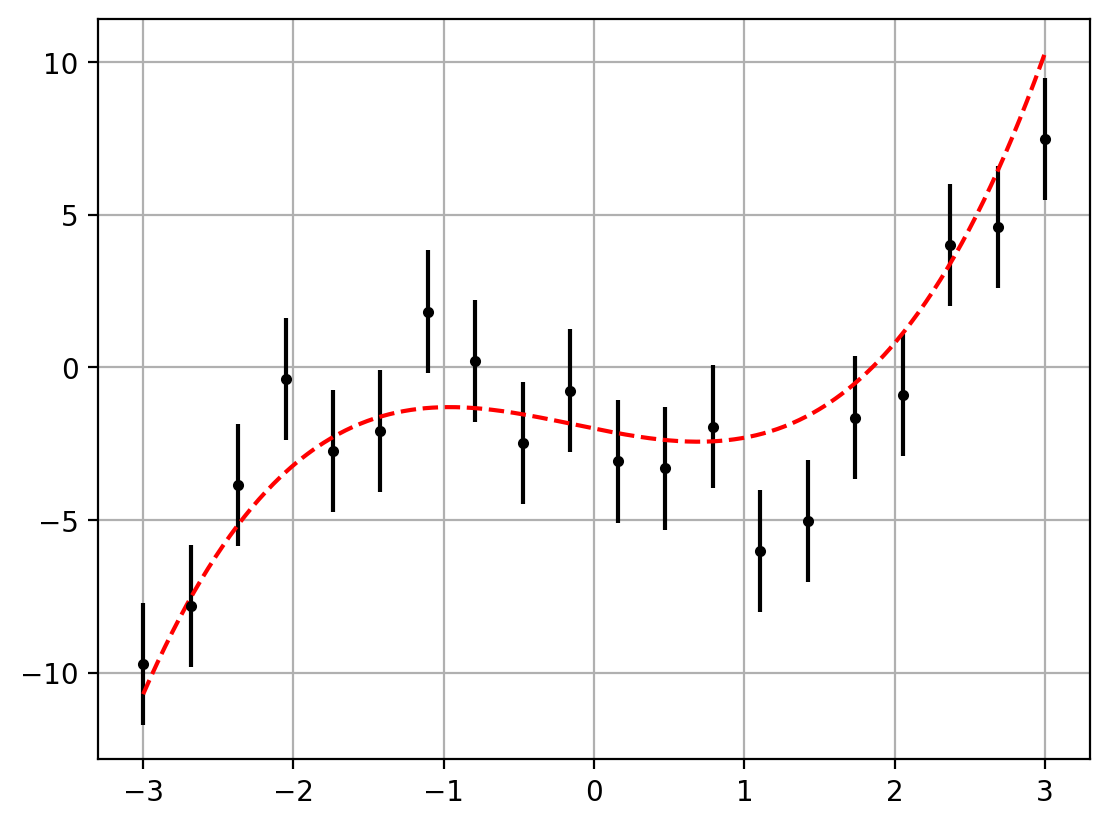

In [17]:
x_plot = np.linspace(x_data.min(), x_data.max(), 500)
truth_curve = lambda x: model_predict([a0_true, a1_true, a2_true, a3_true], x)

plt.errorbar(x_data, y_data, yerr=noise_std, fmt=".k", capsize=0)
plt.plot(x_plot, truth_curve(x_plot), "r--", label="true (noiseless)")
plt.grid()

## Log-likelihood

The log-likelihood assumes independent Gaussian measurement noise with
known standard deviation, and is defined as follows:

  $$\hat{y}(x;a)=\sum_{k=0}^n a_k x^k$$

- Gaussian log-likelihood with known noise standard deviation $\sigma$:

  $$\ln P(y\mid x,a) = -\tfrac{1}{2}\sum_i\left(\frac{(y_i-\hat{y}(x_i;a))^2}{\sigma^2} + \ln(2\pi\sigma^2)\right).$$

In [18]:
def log_likelihood(params, x, y, noise_std):
    model_prediction = model_predict(params, x)
    sigma2 = noise_std**2
    diff = y - model_prediction
    log_likelihood_val = -0.5 * np.sum(diff**2 / sigma2 + np.log(2 * np.pi * sigma2))
    return log_likelihood_val

## Prior

We use independent uniform priors for each polynomial coefficient.

$$
\ln\pi(\theta)=\begin{cases}
-\sum_{i=0}^{D-1}\ln(b_i-a_i), & \text{if } a_i\le\theta_i\le b_i\ \forall i,\\
-\infty, & \text{otherwise.}
\end{cases}
$$

In [19]:
def log_prior(params, bounds):
    """Log-density of independent uniform priors.

    Args:
        params (array-like): parameter vector of shape (D,).
        bounds (sequence): sequence of (low, high) pairs length D.

    Returns:
        float: log prior (finite) when all params within bounds, otherwise -inf.
    """
    params = np.asarray(params)
    bnds = np.asarray(bounds, dtype=float)

    lows = bnds[:, 0]
    highs = bnds[:, 1]

    widths = highs - lows
    return -np.sum(np.log(widths))

## Model posteriors and prior bounds

We define a log-posterior function for each polynomial model (linear, quadratic, cubic, quartic).

Each posterior is the sum of the uniform prior and the Gaussian log-likelihood.

We also set the boundaries of the uniform prior. Since in this case we don't have any strong prior information about the polynomial coefficients, we should also explore different possibilities and see if the conclusions change.

In [20]:
prior_bound = 4.0
param_bounds_linear = [(-prior_bound, prior_bound)] * 2
param_bounds_quadratic = [(-prior_bound, prior_bound)] * 3
param_bounds_cubic = [(-prior_bound, prior_bound)] * 4
param_bounds_quartic = [(-prior_bound, prior_bound)] * 5


# Model A: Linear (order 1)
def log_posterior_linear(params):
    lp = log_prior(params, param_bounds_linear)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std)


# Model B: Quadratic (order 2) - The True Model
def log_posterior_quadratic(params):
    lp = log_prior(params, param_bounds_quadratic)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std)


# Model C: Cubic (order 3)
def log_posterior_cubic(params):
    lp = log_prior(params, param_bounds_cubic)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std)


# Model D: Quartic (order 4)
def log_posterior_quartic(params):
    lp = log_prior(params, param_bounds_quartic)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std)

## MCMC sampling with emcee

Again, use `emcee` to obtain posterior samples.

In [21]:
print("\n--- Running MCMC with emcee ---")

# Define common emcee sampling parameters
nwalkers = 32  # Number of MCMC walkers
nsteps = 1000  # Number of steps per walker
nburn = 500  # Number of burn-in steps to discard


# Helper function to run emcee and return samples
def run_mcmc_sampler(log_posterior_func, ndim, initial_guess, model_name):
    """
    Runs the emcee sampler for a given log-posterior function.

    Args:
        log_posterior_func (callable): The log-posterior function.
        ndim (int): The number of dimensions (parameters) for the model.
        initial_guess (np.ndarray): An initial guess for the parameters.
        model_name (str): Name of the model for printing progress.

    Returns:
        np.ndarray: 3D array of posterior samples after burn-in (nwalkers, nsteps-nburn, ndim).
        np.ndarray: 2D array of log-probabilities after burn-in (nwalkers, nsteps-nburn).
    """
    print(f"  Sampling for {model_name} model ({ndim} parameters)...")

    # Initialize walkers in a small ball around the initial guess
    pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

    # Instantiate the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_func)

    # Run the MCMC
    sampler.run_mcmc(pos, nsteps, progress=True)

    # Get the chain of samples and log-probabilities, discarding burn-in
    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])

    print(
        f"  Finished sampling for {model_name}. Collected {samples.shape[0] * samples.shape[1]} samples."
    )
    return samples, log_prob


# Initial guesses for parameters (can be based on true values or rough estimates)
# For linear: [a_0, a_1]
initial_guess_linear = np.array([a0_true, a1_true])
# For quadratic: [a_0, a_1, a_2]
initial_guess_quadratic = np.array([a0_true, a1_true, a2_true])
# For cubic: [a_0, a_1, a_2, a_3]
initial_guess_cubic = np.array([a0_true, a1_true, a2_true, a3_true])
# For quartic: [a_0, a_1, a_2, a_3, a_4]
initial_guess_quartic = np.array(
    [a0_true, a1_true, a2_true, a3_true, a4_true if a4_true != 0 else 0.01]
)

# Run MCMC for each model
samples_linear, log_prob_linear = run_mcmc_sampler(
    log_posterior_linear,
    ndim=2,
    initial_guess=initial_guess_linear,
    model_name="linear",
)
samples_quadratic, log_prob_quadratic = run_mcmc_sampler(
    log_posterior_quadratic,
    ndim=3,
    initial_guess=initial_guess_quadratic,
    model_name="quadratic",
)
samples_cubic, log_prob_cubic = run_mcmc_sampler(
    log_posterior_cubic,
    ndim=4,
    initial_guess=initial_guess_cubic,
    model_name="cubic",
)
samples_quartic, log_prob_quartic = run_mcmc_sampler(
    log_posterior_quartic,
    ndim=5,
    initial_guess=initial_guess_quartic,
    model_name="quartic",
)


--- Running MCMC with emcee ---
  Sampling for linear model (2 parameters)...


100%|██████████| 1000/1000 [00:01<00:00, 541.64it/s]


  Finished sampling for linear. Collected 16000 samples.
  Sampling for quadratic model (3 parameters)...


100%|██████████| 1000/1000 [00:01<00:00, 528.46it/s]


  Finished sampling for quadratic. Collected 16000 samples.
  Sampling for cubic model (4 parameters)...


100%|██████████| 1000/1000 [00:01<00:00, 507.17it/s]


  Finished sampling for cubic. Collected 16000 samples.
  Sampling for quartic model (5 parameters)...


100%|██████████| 1000/1000 [00:02<00:00, 341.32it/s]

  Finished sampling for quartic. Collected 16000 samples.


## Evidence estimation with harmonic

In [22]:
print("\n--- Computing log-evidence with harmonic ---")

# Define common harmonic parameters
training_proportion = 0.5  # Proportion of samples to use for training the flow model
temperature = 0.8  # Temperature parameter for the RQSplineModel


# Helper function to compute log-evidence for a given model
def compute_log_evidence(samples, log_prob, ndim, model_name):
    """Compute ln(Z) and an approximate error using harmonic's normalizing flow.

    This helper trains a flow on a split of the provided posterior samples and
    uses harmonic's Evidence object to obtain an estimate of the inverse
    evidence. The function returns ln(Z) and a symmetric error estimate.
    """
    print(f"  Computing log-evidence for {model_name} model...")

    chains = hm.Chains(ndim)
    chains.add_chains_3d(samples, log_prob)

    chains_train, chains_infer = hm.utils.split_data(
        chains, training_proportion=training_proportion
    )

    model = hm.model.RQSplineModel(ndim, standardize=True, temperature=temperature)
    epochs_num = 10
    print(f"    Training RQSplineModel for {model_name} with {epochs_num} epochs...")
    model.fit(chains_train.samples, epochs=epochs_num, verbose=True)

    ev = hm.Evidence(chains_infer.nchains, model)
    ev.add_chains(chains_infer)

    ln_evidence_inv = ev.ln_evidence_inv
    err_tuple = ev.compute_ln_inv_evidence_errors()
    err_ln_evidence_inv = (abs(err_tuple[0]) + abs(err_tuple[1])) / 2

    print("kurtosis = {}".format(ev.kurtosis), " Aim for ~3.")
    check = np.exp(0.5 * ev.ln_evidence_inv_var_var - ev.ln_evidence_inv_var)

    print("sqrt(evidence_inv_var_var) / evidence_inv_var = {}".format(check))
    print(" Aim for sqrt( 2/(n_eff-1) ) = {}".format(np.sqrt(2.0 / (ev.n_eff - 1))))
    print()

    return -ln_evidence_inv, err_ln_evidence_inv


# Compute log-evidence for each model
ln_Z_linear, err_ln_Z_linear = compute_log_evidence(
    samples=samples_linear,
    log_prob=log_prob_linear,
    ndim=2,
    model_name="linear (order 1)",
)
ln_Z_quadratic, err_ln_Z_quadratic = compute_log_evidence(
    samples=samples_quadratic,
    log_prob=log_prob_quadratic,
    ndim=3,
    model_name="quadratic (order 2)",
)
ln_Z_cubic, err_ln_Z_cubic = compute_log_evidence(
    samples=samples_cubic, log_prob=log_prob_cubic, ndim=4, model_name="cubic (order 3)"
)
ln_Z_quartic, err_ln_Z_quartic = compute_log_evidence(
    samples=samples_quartic,
    log_prob=log_prob_quartic,
    ndim=5,
    model_name="quartic (order 4)",
)


--- Computing log-evidence with harmonic ---
  Computing log-evidence for linear (order 1) model...
    Training RQSplineModel for linear (order 1) with 10 epochs...


Training NF: 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


kurtosis = 3.829780273393634  Aim for ~3.
sqrt(evidence_inv_var_var) / evidence_inv_var = 0.4034460208947117
 Aim for sqrt( 2/(n_eff-1) ) = 0.3651483716701107

  Computing log-evidence for quadratic (order 2) model...
    Training RQSplineModel for quadratic (order 2) with 10 epochs...


Training NF: 100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


kurtosis = 2.395561032245417  Aim for ~3.
sqrt(evidence_inv_var_var) / evidence_inv_var = 0.28980109703650275
 Aim for sqrt( 2/(n_eff-1) ) = 0.3651483716701107

  Computing log-evidence for cubic (order 3) model...
    Training RQSplineModel for cubic (order 3) with 10 epochs...


Training NF: 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


kurtosis = 2.1849526697793276  Aim for ~3.
sqrt(evidence_inv_var_var) / evidence_inv_var = 0.2691014919392882
 Aim for sqrt( 2/(n_eff-1) ) = 0.3651483716701107

  Computing log-evidence for quartic (order 4) model...
    Training RQSplineModel for quartic (order 4) with 10 epochs...


Training NF: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it]


kurtosis = 2.306307913016165  Aim for ~3.
sqrt(evidence_inv_var_var) / evidence_inv_var = 0.2812149632814703
 Aim for sqrt( 2/(n_eff-1) ) = 0.3651483716701107



## Evidence table

Compare log-evidence (ln Z) and estimated errors across models.

In [23]:
print("\n--- Log-evidence comparison ---\n")
print("| model      |  log-evidence (ln Z) | error (ln Z) |")
print("|------------|----------------------|--------------|")

row_fmt = "| {model:<10} | {lnz:>20.3f} | {err:>12.3f} |"
print(row_fmt.format(model="linear", lnz=ln_Z_linear, err=err_ln_Z_linear))
print(row_fmt.format(model="quadratic", lnz=ln_Z_quadratic, err=err_ln_Z_quadratic))
print(row_fmt.format(model="cubic", lnz=ln_Z_cubic, err=err_ln_Z_cubic))
print(row_fmt.format(model="quartic", lnz=ln_Z_quartic, err=err_ln_Z_quartic))


--- Log-evidence comparison ---

| model      |  log-evidence (ln Z) | error (ln Z) |
|------------|----------------------|--------------|
| linear     |              -61.608 |        0.009 |
| quadratic  |              -64.076 |        0.049 |
| cubic      |              -48.236 |        0.026 |
| quartic    |              -52.248 |        0.034 |


In [24]:
# --- Helper plotting functions ---

def plot_posterior_predictives(
    samples_dict, x_data, y_data, x_plot, truth_curve, noise_std
):
    """Plot posterior predictive draws for each model in a 2x2 grid.

    Args:
        samples_dict (dict): mapping name->flattened samples (n_samples, ndim)
        x_data, y_data: observed data
        x_plot: dense x for smooth curves
        truth_curve: callable(x) -> y (true noiseless curve)
        noise_std: observational noise std for errorbars
    """
    panel_order = ["linear", "quadratic", "cubic", "quartic"]
    display = {
        "linear": "linear (order 1)",
        "quadratic": "quadratic (order 2)",
        "cubic": "cubic (order 3)",
        "quartic": "quartic (order 4)",
    }
    colors = {"linear": "C0", "quadratic": "C1", "cubic": "C2", "quartic": "C3"}

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, name in zip(axes, panel_order):
        flat = samples_dict.get(name)
        ax.errorbar(x_data, y_data, yerr=noise_std, fmt=".k", capsize=0)
        ax.plot(x_plot, truth_curve(x_plot), "r--", label="true (noiseless)")

        if flat is not None and flat.shape[0] > 0:
            n_draws = min(25, flat.shape[0])
            idx = np.random.choice(flat.shape[0], size=n_draws, replace=False)
            for params in flat[idx]:
                ax.plot(
                    x_plot,
                    model_predict(params, x_plot),
                    color=colors[name],
                    alpha=0.18,
                )
            meanp = np.mean(flat, axis=0)
            ax.plot(
                x_plot,
                model_predict(meanp, x_plot),
                color=colors[name],
                lw=2,
                label="posterior mean",
            )

        ax.set_title(display[name])
        ax.grid(True)

    fig.suptitle("posterior predictive samples (25 draws per model)", fontsize=18)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    return fig


def plot_model_probabilities(ln_Zs, labels):
    """Plot normalized model probabilities from ln Z values."""
    ln_Zs = np.asarray(ln_Zs)
    Zs = np.exp(ln_Zs - np.max(ln_Zs))
    probs = Zs / np.sum(Zs)

    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(len(labels))
    ax.bar(x, probs, color=["C0", "C1", "C2", "C3"], capsize=6)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, ha="right")
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_ylabel("Model probability")
    ax.set_ylim(0, 1.1)
    for i, p in enumerate(probs):
        ax.text(i, p + 0.02, f"{p:.2f}", ha="center")
    plt.tight_layout()
    return fig

In [25]:
# Helper cell to prepare data for plotting
flat_linear = samples_linear.reshape(-1, samples_linear.shape[2])
flat_quadratic = samples_quadratic.reshape(-1, samples_quadratic.shape[2])
flat_cubic = samples_cubic.reshape(-1, samples_cubic.shape[2])
flat_quartic = samples_quartic.reshape(-1, samples_quartic.shape[2])

samples_for_plot = {
    "linear": flat_linear,
    "quadratic": flat_quadratic,
    "cubic": flat_cubic,
    "quartic": flat_quartic,
}

# Dense x for plotting
x_plot = np.linspace(x_data.min(), x_data.max(), 500)


def _truth_curve(x):
    if truth_model == "quadratic":
        return model_predict([a0_true, a1_true, a2_true], x)
    return model_predict([a0_true, a1_true, a2_true, a3_true], x)

## Plot the posterior predictives

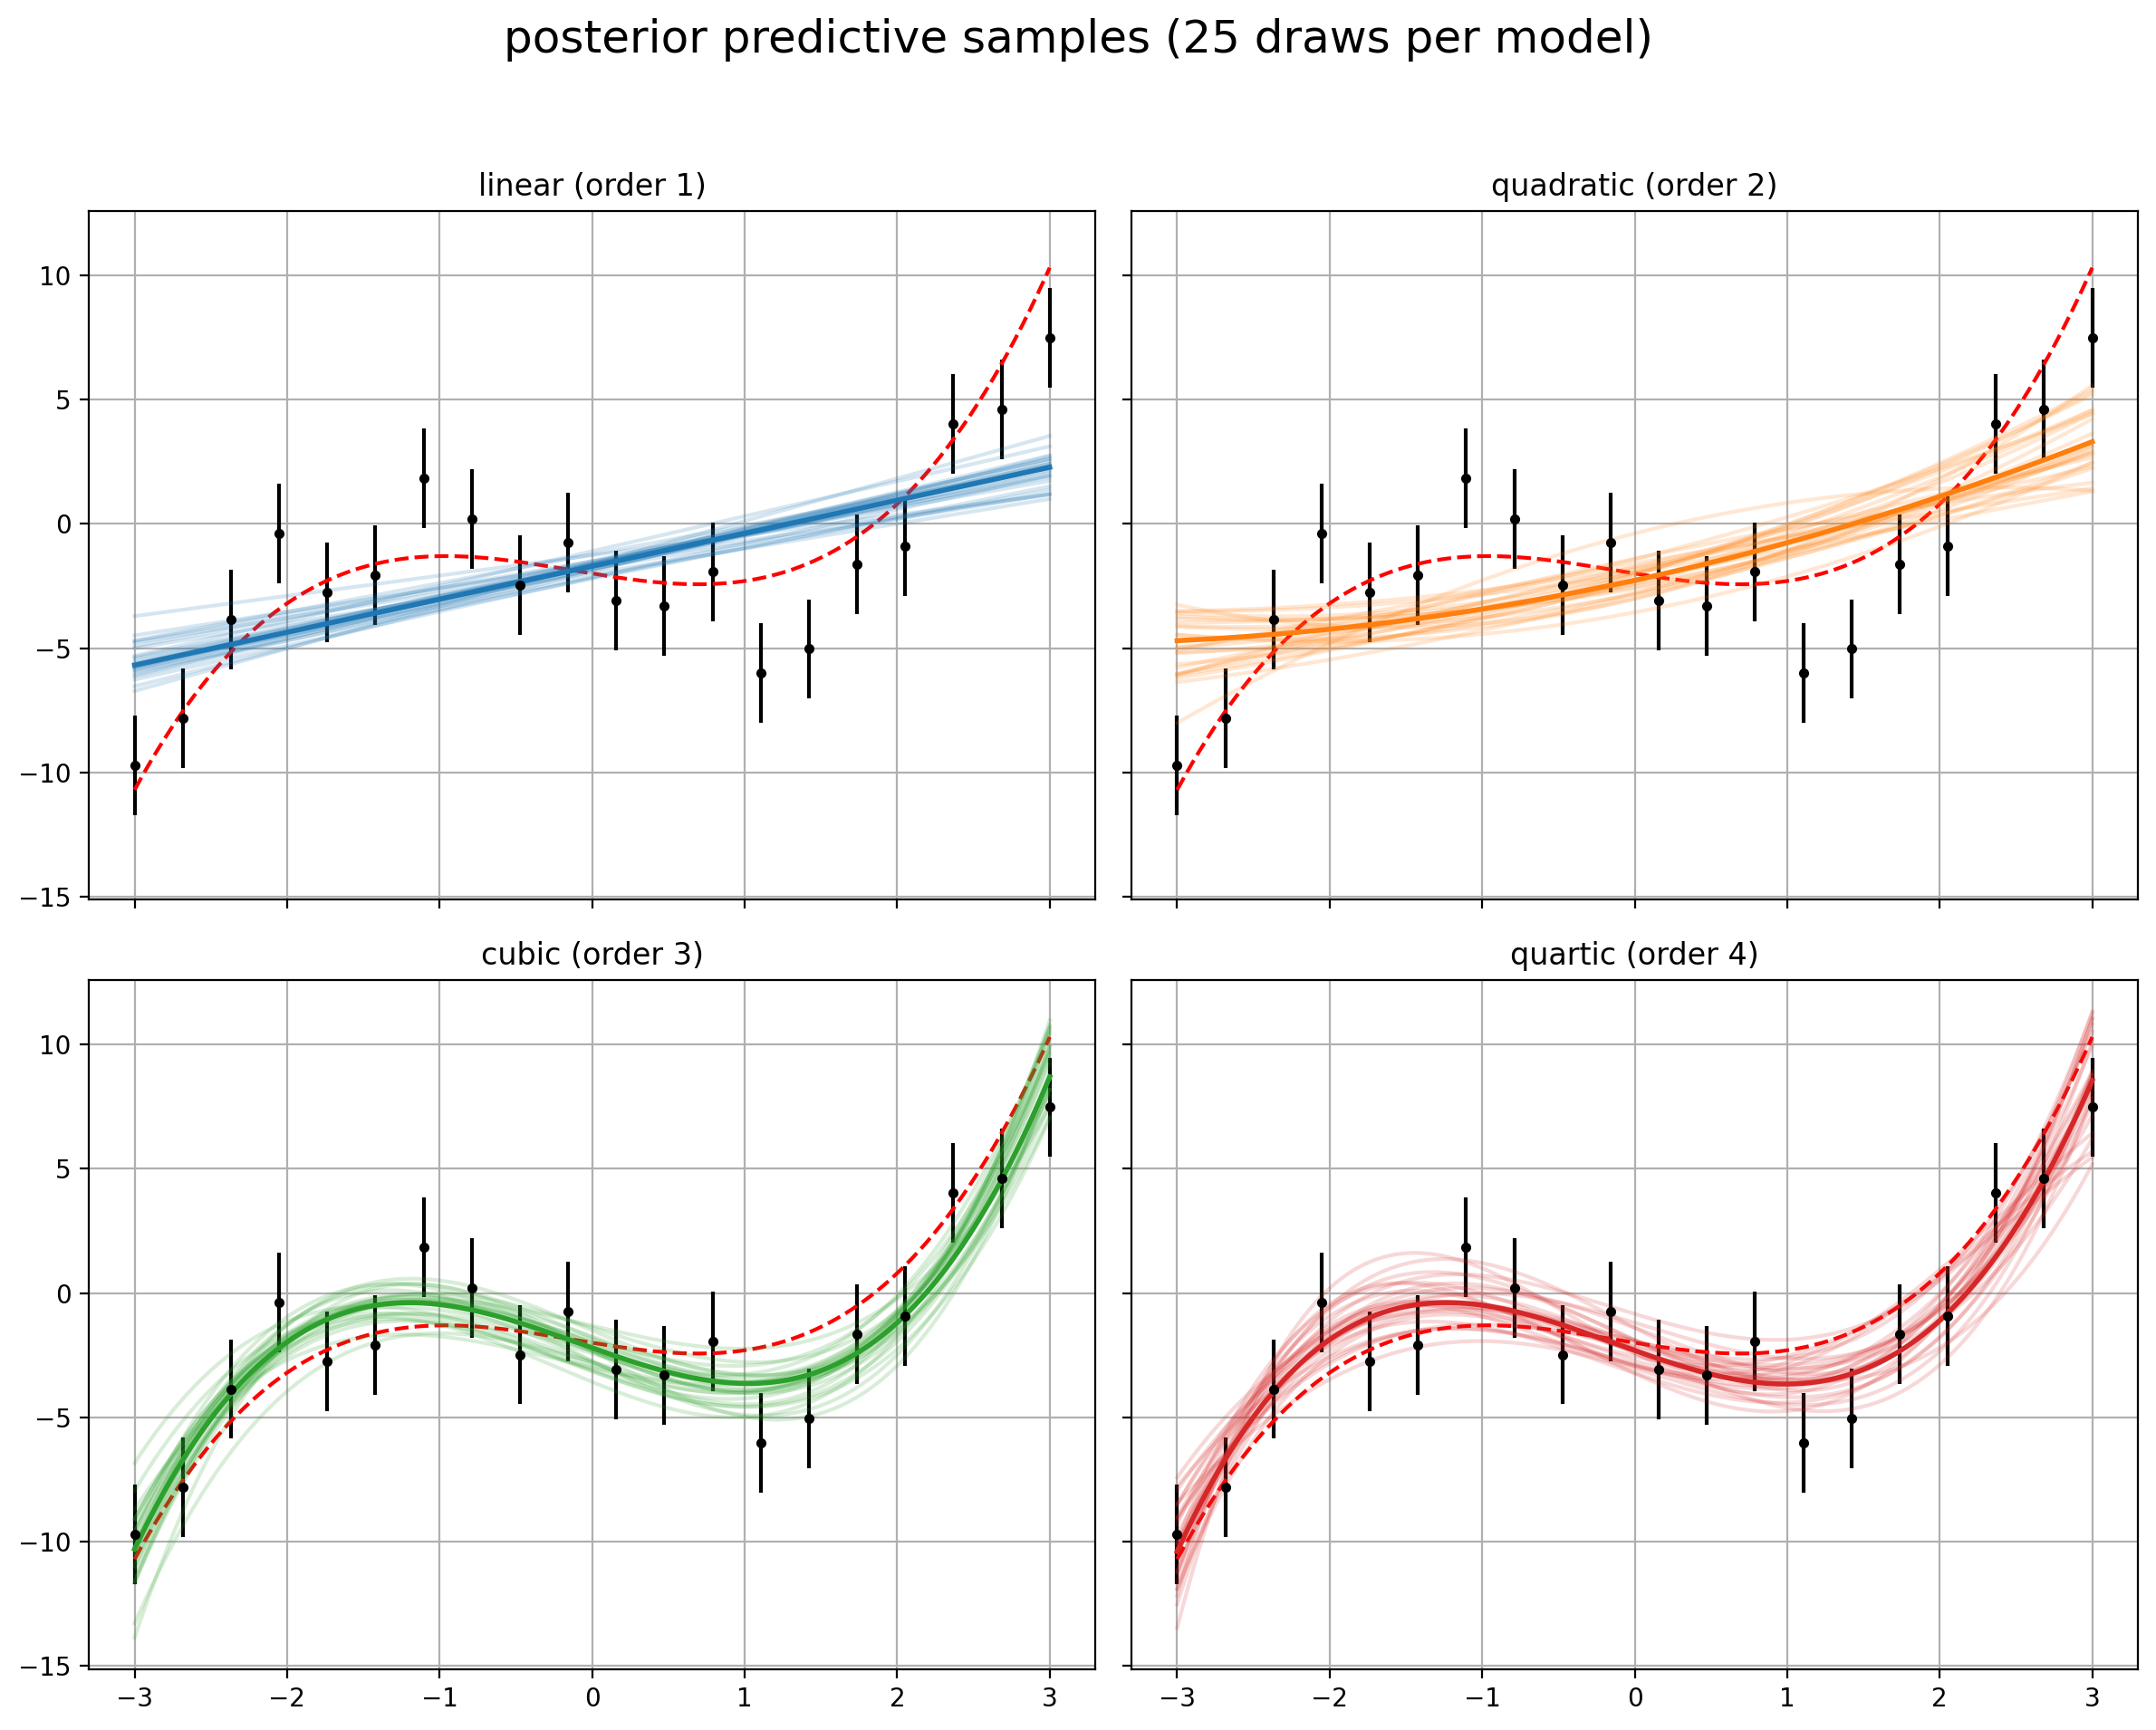

In [26]:
fig1 = plot_posterior_predictives(
    samples_dict=samples_for_plot,
    x_data=x_data,
    y_data=y_data,
    x_plot=x_plot,
    truth_curve=_truth_curve,
    noise_std=noise_std,
)
plt.show()

## Plot the model probabilities

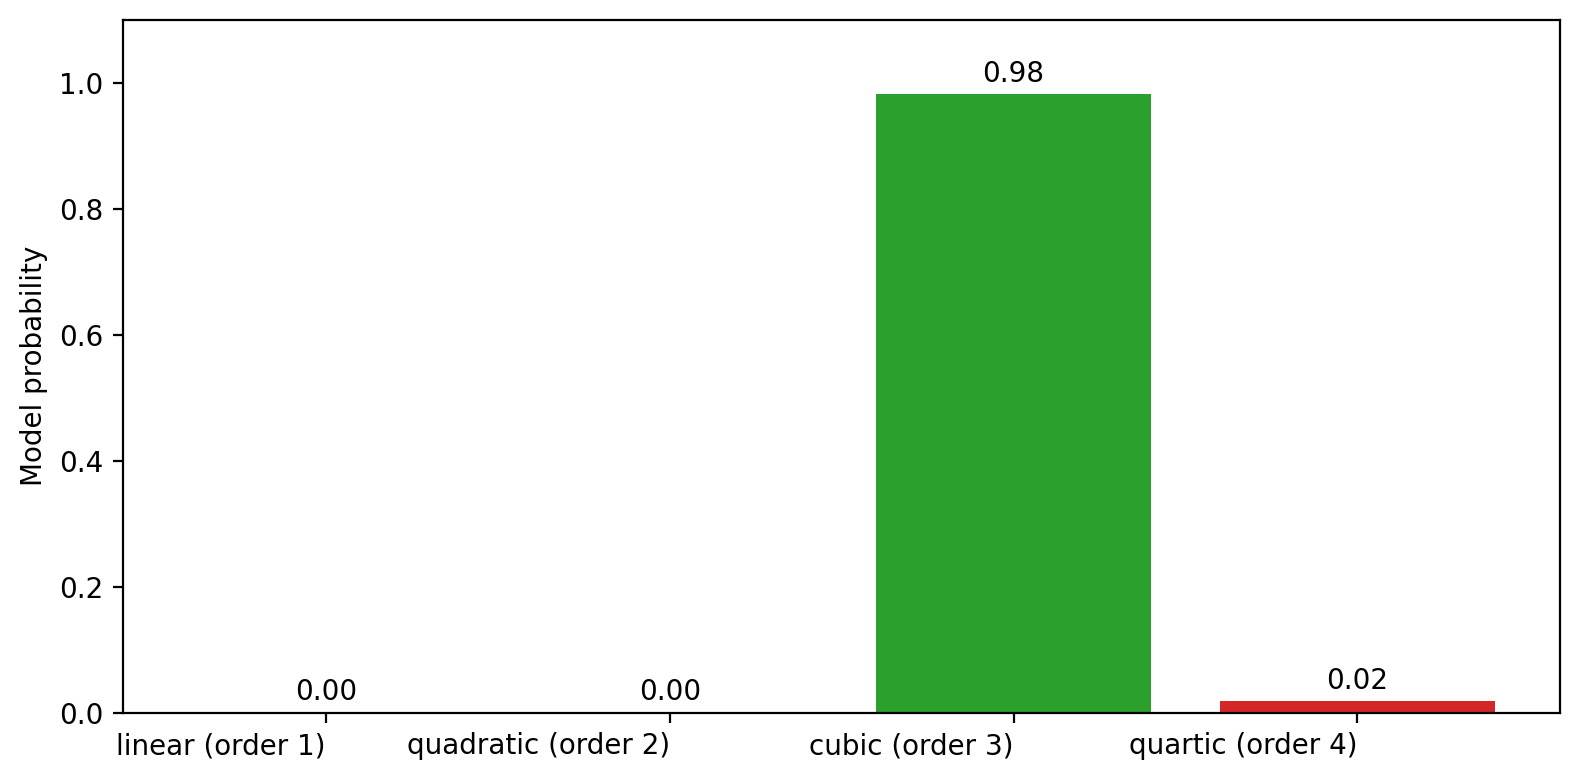

In [27]:
fig2 = plot_model_probabilities(
    ln_Zs=[ln_Z_linear, ln_Z_quadratic, ln_Z_cubic, ln_Z_quartic],
    labels=[
        "linear (order 1)",
        "quadratic (order 2)",
        "cubic (order 3)",
        "quartic (order 4)",
    ],
)
plt.show()

Can you see if the conclusions change with different prior bounds that you could have reasonably picked?

# Part 4. Real World Example - Radiata Pines

Let's now consider a real world example using everyone's favorite New Zealand tree!

## The Radiata Pines Dataset

Radiata pine (*Pinus radiata*) is New Zealand's most important commercial timber species. These fast-growing trees are a cornerstone of New Zealand's forestry industry.

While you're here for MaxEnt 2025 in Auckland, you might go on a hike and spot a radiata pine. You might even wonder: "Is density or resin-adjusted density a better predictor of compression strength parallel to the grain?" Well, today's your lucky day - we're going to use Bayesian model selection to answer exactly that question!

The dataset consists of measurements of the maximum compression strength parallel to the grain $y_i$, density $x_i$ and resin-adjusted density $z_i$, for specimen $i \in \{1, \ldots, n\}$. Two Gaussian linear models are compared, one with density and one with resin-adjusted density as variables:
\begin{align*}
\text{Model } M_1 &: \quad y_i = \alpha + \beta(x_i - \bar{x}) + \epsilon_i, & \epsilon_i &\sim \text{N}(0, \tau^{-1}); \\
\text{Model } M_2 &: \quad y_i = \gamma + \delta(z_i - \bar{z}) + \eta_i, & \eta_i &\sim \text{N}(0, \lambda^{-1}),
\end{align*}
where $\bar{x}$, $\bar{z}$ denote the mean values of $x_i$ and $z_i$ respectively, and $\tau$ and $\lambda$ denote the precision of the noise for the respective models. For both models, Gaussian priors with means $\mu_\alpha = 3000$ and $\mu_\beta = 185$, and precision scales $r_0 = 0.06$ and $s_0 = 6$ are chosen. A gamma prior is assumed for the noise precision with shape $a_0 = 3$ and rate $b_0 = 2 \times 300^2$.

Let's first get the dataset.

In [28]:
url = "https://raw.githubusercontent.com/astro-informatics/harmonic/refs/heads/main/examples/data/radiata_pine.dat"

radiata_data = np.loadtxt(url)

Now, let's define the necessary densities.

In [29]:
# ===========================================================================
# Set-up Priors
# ===========================================================================
# Define prior variables
mu_0 = np.array([[3000.0], [185.0]])
r_0 = 0.06
s_0 = 6.0
a_0 = 3.0
b_0 = 2.0 * 300**2

# Imports data file
id = radiata_data[:, 0]
y = radiata_data[:, 1]
x = radiata_data[:, 2]
z = radiata_data[:, 3]
n = len(x)

# Ensure column vectors
y = y.reshape(n, 1)
x = x.reshape(n, 1)
z = z.reshape(n, 1)

# Remove means from covariates.
x = x - np.mean(x)
z = z - np.mean(z)

def ln_likelihood_pine(y, x, n, alpha, beta, tau):
    """Compute log_e of Radiata Pine likelihood.

    Args:

        y: Compression strength along grain.

        x: Predictor (density or density adjusted for resin content).

        alpha: Model bias term.

        beta: Model linear term.

        tau: Prior precision factor.

    Returns:

        double: Value of log_e likelihood at specified point in parameter
            space.

    """

    ln_like = 0.5 * n * np.log(tau)
    ln_like -= 0.5 * n * np.log(2.0 * np.pi)

    s = np.sum((y - alpha - beta * x) ** 2)

    ln_like -= 0.5 * tau * s

    return ln_like


def ln_prior_alpha(alpha, tau, mu_0, r_0):
    """Compute log_e of alpha / beta prior (Normal prior).

    Args:

        alpha: Model term (bias or linear term).

        tau: Prior precision factor.

        mu_0: Prior mean.

        r_0: Prior precision constant factor.

    Returns:

        double: Value of log_e prior at specified point in parameter space.

    """
    ln_pr_alpha = 0.5 * np.log(tau)
    ln_pr_alpha += 0.5 * np.log(r_0)
    ln_pr_alpha -= 0.5 * np.log(2.0 * np.pi)
    ln_pr_alpha -= 0.5 * tau * r_0 * (alpha - mu_0) ** 2

    return ln_pr_alpha


def ln_prior_tau(tau, a_0, b_0):
    """Compute log_e of tau prior (Gamma prior).

    Args:

        tau: Prior precision factor.

        a_0: Gamma prior shape parameter.

        b_0: Gamma prior rate parameter.

    Returns:

        double: Value of log_e tau prior at specified point in parameter
            space.

    """

    if tau < 0:
        return -np.inf

    ln_pr_tau = a_0 * np.log(b_0)
    ln_pr_tau += (a_0 - 1.0) * np.log(tau)
    ln_pr_tau -= b_0 * tau
    ln_pr_tau -= sp.gammaln(a_0)

    return ln_pr_tau


def ln_prior_separated(alpha, beta, tau, mu_0, r_0, s_0, a_0, b_0):
    """Compute log_e of prior (combining individual prior functions).

    Args:

        alpha: Model bias term.

        beta: Model linear term.

        tau: Prior precision factor.

        mu_0: Prior means.

        r_0: Prior precision constant factor for bias term.

        s_0: Prior precision constant factor for linear term.

        a_0: Gamma prior shape parameter.

        b_0: Gamma prior rate parameter.

    Returns:

        double: Value of log_e prior at specified point in parameter space.

    """
    ln_pr = ln_prior_alpha(alpha, tau, mu_0[0, 0], r_0)
    ln_pr += ln_prior_alpha(beta, tau, mu_0[1, 0], s_0)
    ln_pr += ln_prior_tau(tau, a_0, b_0)

    return ln_pr


def ln_prior_combined(alpha, beta, tau, mu_0, r_0, s_0, a_0, b_0):
    """Compute log_e of combined prior (jointly computing total prior).

    Args:

        alpha: Model bias term.

        beta: Model linear term.

        tau: Prior precision factor.

        mu_0: Prior means.

        r_0: Prior precision constant factor for bias term.

        s_0: Prior precision constant factor for linear term.

        a_0: Gamma prior shape parameter.

        b_0: Gamma prior rate parameter.

    Returns:

        double: Value of log_e prior at specified point in parameter space.

    """
    if tau < 0:
        return -np.inf

    ln_pr = a_0 * np.log(b_0)
    ln_pr += a_0 * np.log(tau)
    ln_pr -= b_0 * tau
    ln_pr -= np.log(2.0 * np.pi)
    ln_pr -= sp.gammaln(a_0)
    ln_pr += 0.5 * np.log(r_0)
    ln_pr += 0.5 * np.log(s_0)
    ln_pr -= (
        0.5 * tau * (r_0 * (alpha - mu_0[0, 0]) ** 2 + s_0 * (beta - mu_0[1, 0]) ** 2)
    )

    return ln_pr


def ln_prior_pine(alpha, beta, tau, mu_0, r_0, s_0, a_0, b_0):
    """Compute log_e of combined prior.

    Can be used to easily switch with prior function using (e.g.
    ln_prior_separated or ln_prior_combined). There should be (and is) not
    difference (both implemented just as an additional consistency check).

    Args:

        alpha: Model bias term.

        beta: Model linear term.

        tau: Prior precision factor.

        mu_0: Prior means.

        r_0: Prior precision constant factor for bias term.

        s_0: Prior precision constant factor for linear term.

        a_0: Gamma prior shape parameter.

        b_0: Gamma prior rate parameter.

    Returns:

        double: Value of log_e prior at specified point in parameter space.

    """

    return ln_prior_combined(alpha, beta, tau, mu_0, r_0, s_0, a_0, b_0)


def ln_posterior_pine(theta, y, x, n, mu_0, r_0, s_0, a_0, b_0):
    """Compute log_e of posterior.

    Args:

        theta: Position (alpha, beta, tau) at which to evaluate posterior.

        y: Compression strength along grain.

        x: Predictor (density or density adjusted for resin content).

        n: Number of specimens.

        mu_0: Prior means.

        r_0: Prior precision constant factor for bias term.

        s_0: Prior precision constant factor for linear term.

        a_0: Gamma prior shape parameter.

        b_0: Gamma prior rate parameter.

    Returns:

        double: Value of log_e posterior at specified theta (alpha, beta,
            tau) point.

    """

    alpha, beta, tau = theta

    ln_pr = ln_prior_pine(alpha, beta, tau, mu_0, r_0, s_0, a_0, b_0)

    if not np.isfinite(ln_pr):
        return -np.inf

    ln_L = ln_likelihood_pine(y, x, n, alpha, beta, tau)

    return ln_L + ln_pr


def ln_evidence_analytic_pine(x, y, n, mu_0, r_0, s_0, a_0, b_0):
    """Compute log_e of analytic evidence.

    Args:

        x: Predictor (density or density adjusted for resin content).

        y: Compression strength along grain.

        n: Number of specimens.

        mu_0: Prior means.

        r_0: Prior precision constant factor for bias term.

        s_0: Prior precision constant factor for linear term.

        a_0: Gamma prior shape parameter.

        b_0: Gamma prior rate parameter.

    Returns:

        double: Value of log_e of analytic evidence for model.

    """

    Q_0 = np.diag([r_0, s_0])
    X = np.c_[np.ones((n, 1)), x]
    M = X.T.dot(X) + Q_0
    nu_0 = np.linalg.inv(M).dot(X.T.dot(y) + Q_0.dot(mu_0))

    quad_terms = y.T.dot(y) + mu_0.T.dot(Q_0).dot(mu_0) - nu_0.T.dot(M).dot(nu_0)

    ln_evidence = -0.5 * n * np.log(np.pi)
    ln_evidence += a_0 * np.log(2.0 * b_0)
    ln_evidence += sp.gammaln(0.5 * n + a_0) - sp.gammaln(a_0)
    ln_evidence += 0.5 * np.log(np.linalg.det(Q_0)) - 0.5 * np.log(np.linalg.det(M))

    ln_evidence += -(0.5 * n + a_0) * np.log(quad_terms + 2.0 * b_0)

    return ln_evidence

Get our samples from the posterior.

In [30]:
def get_radiata_samples(model_1=True, nchains=60, samples_per_chain=1500, nburn=1000):
    """
    Run MCMC sampling for radiata pine regression models.

    Args:
        model_1: If True, use density (x) as predictor.
                 If False, use resin-adjusted density (z) as predictor.
        nchains: Number of MCMC chains to run.
        samples_per_chain: Total number of samples per chain (including burn-in).
        nburn: Number of burn-in samples to discard.

    Returns:
        samples: Posterior samples array of shape (nchains, nsamples, ndim)
        lnprob: Log probability values of shape (nchains, nsamples)
    """

    # Set up and run sampler.
    tau_prior_mean = a_0 / b_0
    tau_prior_std = np.sqrt(a_0) / b_0

    # ===========================================================================
    # Compute random positions to draw from for emcee sampler.
    # ===========================================================================
    # Initial positions for each chain drawn from priors
    pos_alpha = mu_0[0, 0] + 1.0 / np.sqrt(tau_prior_mean * r_0) * np.random.randn(
        nchains
    )
    pos_beta = mu_0[1, 0] + 1.0 / np.sqrt(tau_prior_mean * s_0) * np.random.randn(
        nchains
    )
    pos_tau = tau_prior_mean + tau_prior_std * (
        np.random.rand(nchains) - 0.5
    )  # avoid negative tau

    # Concatenate positions
    pos = np.c_[pos_alpha, pos_beta, pos_tau]

    # ===========================================================================
    # Run Emcee to recover posterior samples
    # ===========================================================================
    # Select appropriate predictor variable
    ndim = 3  # alpha, beta, tau
    if model_1:
        args = (y, x, n, mu_0, r_0, s_0, a_0, b_0)
    else:
        args = (y, z, n, mu_0, r_0, s_0, a_0, b_0)

    sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior_pine, args=args)
    rstate = np.random.get_state()
    sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate)

    # Extract samples after burn-in
    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    lnprob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])

    return samples, lnprob

Train the flow...

In [31]:
# Which model we use
model_1 = True
# initialise random seed
np.random.seed(26)

samples_pine, lnprob_pine = get_radiata_samples(model_1=model_1)
print("Pine samples shape:", samples_pine.shape)
print("Pine lnprob shape:", lnprob_pine.shape)
chains_pine = hm.Chains(3)
chains_pine.add_chains_3d(samples_pine, lnprob_pine)
chains_train_pine, chains_infer_pine = hm.utils.split_data(
    chains_pine, training_proportion=0.5
)


Pine samples shape: (60, 500, 3)
Pine lnprob shape: (60, 500)


In [39]:
# Spline parameters
temperature = 0.8
epochs_num = 5
n_layers = 10
n_bins = 8
hidden_size = [64, 64]
spline_range = (-10.0, 10.0)
standardize = True
learning_rate = 0.001
model_pine = hm.model.RQSplineModel(
            3,
            n_layers=n_layers,
            n_bins=n_bins,
            hidden_size=hidden_size,
            spline_range=spline_range,
            standardize=standardize,
            temperature=temperature,
            learning_rate=learning_rate,
        )
model_pine.fit(chains_train_pine.samples, epochs=epochs_num, verbose=True)

Training NF: 100%|██████████| 5/5 [00:31<00:00,  6.22s/it]


In [41]:
# Instantiate harmonic's evidence class
ev_pine = hm.Evidence(chains_infer_pine.nchains, model_pine)

# Pass the evidence class the inference chains and compute the evidence!
ev_pine.add_chains(chains_infer_pine)
ln_inv_evidence_pine = ev_pine.ln_evidence_inv
err_ln_inv_evidence_pine = ev_pine.compute_ln_inv_evidence_errors()

Let's look at our flow!

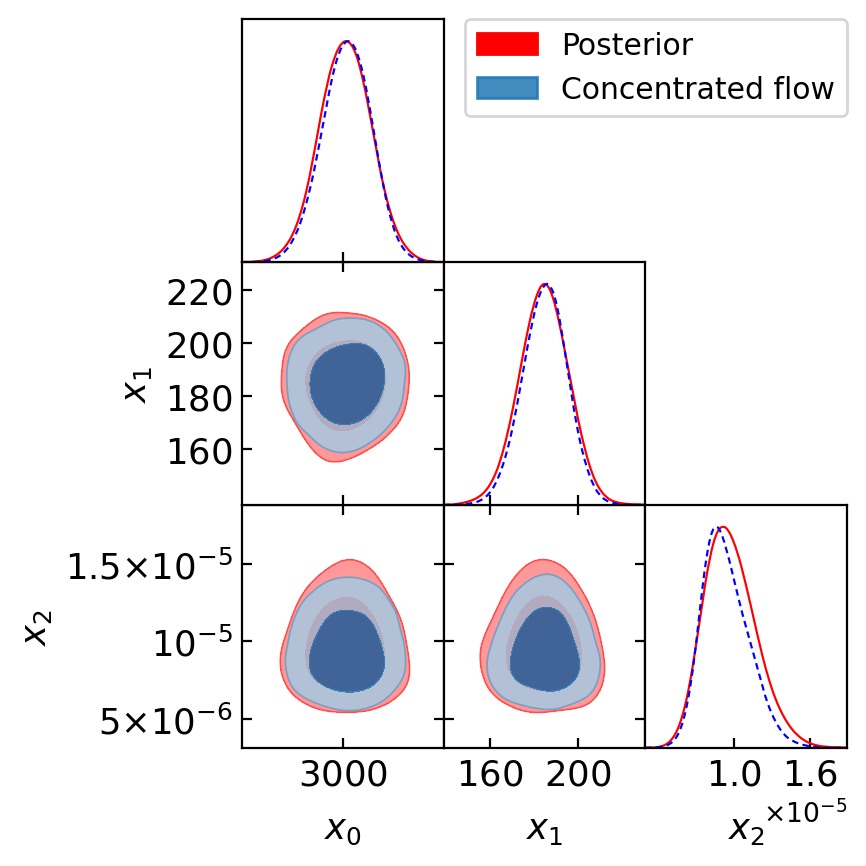

In [42]:
num_samp = chains_train_pine.samples.shape[0]
samps_compressed_pine = np.array(model_pine.sample(num_samp))

hm.utils.plot_getdist_compare(chains_train_pine.samples, samps_compressed_pine)

And check the diagnostics...

In [43]:
print('ln inverse evidence (harmonic) = {} +/- {}'.format(ln_inv_evidence_pine, err_ln_inv_evidence_pine))
print("kurtosis = {}".format(ev_pine.kurtosis))
check = np.exp(0.5 * ev_pine.ln_evidence_inv_var_var - ev_pine.ln_evidence_inv_var)
print("sqrt(evidence_inv_var_var) / evidence_inv_var = {}".format(check))
print("Aim for sqrt( 2/(n_eff-1) ) = {}".format(np.sqrt(2.0 / (ev_pine.n_eff - 1))))

ln inverse evidence (harmonic) = 310.1307490403197 +/- (np.float64(-0.015322354239614793), np.float64(0.015091118323096325))
kurtosis = 4.638987675571534
sqrt(evidence_inv_var_var) / evidence_inv_var = 0.33984684105655477
Aim for sqrt( 2/(n_eff-1) ) = 0.2626128657194451


Does this look good? Hmmm... Can you fix it?

In [50]:
if model_1:
    print("Using Model 1 (density as predictor)")
    ln_evidence_analytic_model1 = ln_evidence_analytic_pine(
        x, y, n, mu_0, r_0, s_0, a_0, b_0
    )
    print(
        "ln_evidence_analytic_model1 = {}".format(ln_evidence_analytic_model1[0][0])
    )
else:
    print("Using Model 2 (resin-adjusted density as predictor)")
    ln_evidence_analytic_model2 = ln_evidence_analytic_pine(
        z, y, n, mu_0, r_0, s_0, a_0, b_0
        )
    print(
        "ln_evidence_analytic_model2 = {}".format(ln_evidence_analytic_model2[0][0])
    )

Using Model 2 (resin-adjusted density as predictor)
ln_evidence_analytic_model2 = -301.70460213436616


Can you calculate the Bayes factor and decide which model is better?

In [45]:
#Model 2
# Which model we use
model_1 = False
# initialise random seed
np.random.seed(26)

samples_pine, lnprob_pine = get_radiata_samples(model_1=model_1)
print("Pine samples shape:", samples_pine.shape)
print("Pine lnprob shape:", lnprob_pine.shape)
chains_pine = hm.Chains(3)
chains_pine.add_chains_3d(samples_pine, lnprob_pine)
chains_train_pine, chains_infer_pine = hm.utils.split_data(
    chains_pine, training_proportion=0.5
)

Pine samples shape: (60, 500, 3)
Pine lnprob shape: (60, 500)


In [46]:
# Spline parameters
temperature = 0.8
epochs_num = 5
n_layers = 10
n_bins = 8
hidden_size = [64, 64]
spline_range = (-10.0, 10.0)
standardize = True
learning_rate = 0.001
model_pine = hm.model.RQSplineModel(
            3,
            n_layers=n_layers,
            n_bins=n_bins,
            hidden_size=hidden_size,
            spline_range=spline_range,
            standardize=standardize,
            temperature=temperature,
            learning_rate=learning_rate,
        )
model_pine.fit(chains_train_pine.samples, epochs=epochs_num, verbose=True)

Training NF: 100%|██████████| 5/5 [00:38<00:00,  7.64s/it]


In [47]:
# Instantiate harmonic's evidence class
ev_pine = hm.Evidence(chains_infer_pine.nchains, model_pine)

# Pass the evidence class the inference chains and compute the evidence!
ev_pine.add_chains(chains_infer_pine)
ln_inv_evidence_pine = ev_pine.ln_evidence_inv
err_ln_inv_evidence_pine = ev_pine.compute_ln_inv_evidence_errors()

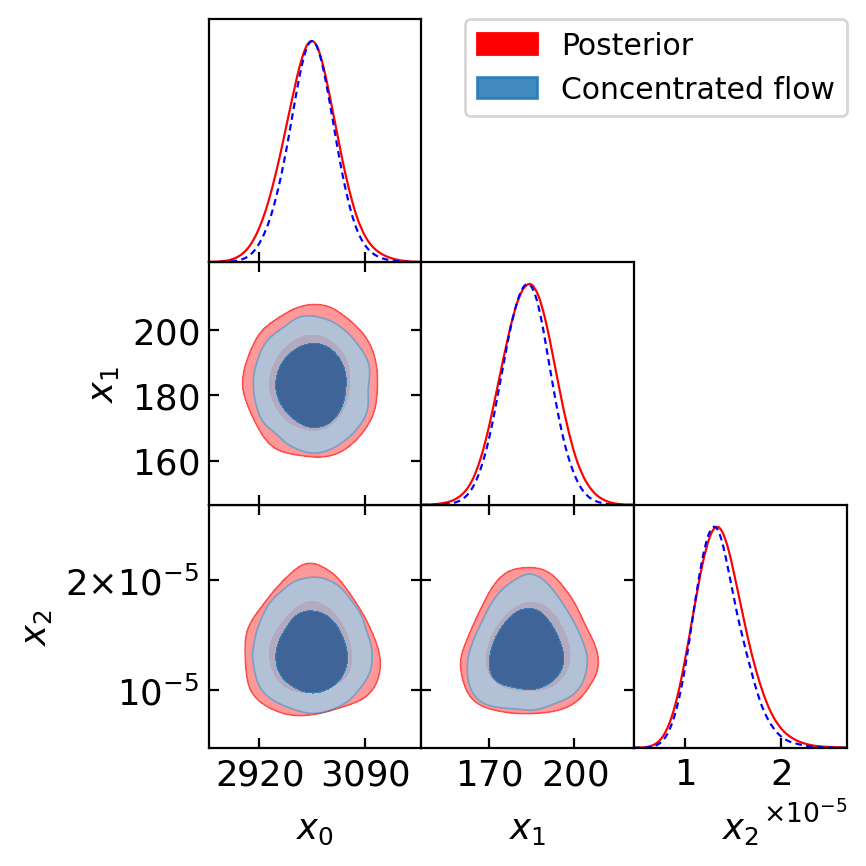

In [48]:
num_samp = chains_train_pine.samples.shape[0]
samps_compressed_pine = np.array(model_pine.sample(num_samp))

hm.utils.plot_getdist_compare(chains_train_pine.samples, samps_compressed_pine)

In [49]:
print('ln inverse evidence (harmonic) = {} +/- {}'.format(ln_inv_evidence_pine, err_ln_inv_evidence_pine))
print("kurtosis = {}".format(ev_pine.kurtosis))
check = np.exp(0.5 * ev_pine.ln_evidence_inv_var_var - ev_pine.ln_evidence_inv_var)
print("sqrt(evidence_inv_var_var) / evidence_inv_var = {}".format(check))
print("Aim for sqrt( 2/(n_eff-1) ) = {}".format(np.sqrt(2.0 / (ev_pine.n_eff - 1))))

ln inverse evidence (harmonic) = 301.7039394318262 +/- (np.float64(-0.011996905914200657), np.float64(0.01185468469176993))
kurtosis = 3.1167420760234457
sqrt(evidence_inv_var_var) / evidence_inv_var = 0.2609228696828958
Aim for sqrt( 2/(n_eff-1) ) = 0.2626128657194451


In [ ]:
if model_1:
    print("Using Model 1 (density as predictor)")
    ln_evidence_analytic_model1 = ln_evidence_analytic_pine(
        x, y, n, mu_0, r_0, s_0, a_0, b_0
    )
    print(
        "ln_evidence_analytic_model1 = {}".format(ln_evidence_analytic_model1[0][0])
    )
else:
    print("Using Model 2 (resin-adjusted density as predictor)")
    ln_evidence_analytic_model2 = ln_evidence_analytic_pine(
        z, y, n, mu_0, r_0, s_0, a_0, b_0
        )
    print(
        "ln_evidence_analytic_model2 = {}".format(ln_evidence_analytic_model2[0][0])
    )